In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.5)
from tqdm import tqdm

from qiskit import QuantumCircuit, Aer
from qiskit.algorithms import VQE
from qiskit.opflow import X, Z, I, Y, AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.algorithms.optimizers import ADAM



In [5]:
def prepare_state():
    theta0 = Parameter('theta0')
    phi0 = Parameter('phi0')
    theta1 = Parameter('theta1')
    phi1 = Parameter('phi1')
    QC = QuantumCircuit(2)
    QC.rx(2*(theta0-np.pi/2),0)
    QC.ry(2*(phi0-np.pi/2),0)
    QC.rx(2*(theta1-np.pi/2),1)
    QC.ry(2*(phi1-np.pi/2),1)
    QC.cx(0,1)
    return QC


QC = prepare_state()
QC.draw()

def Hamiltonian(lmb):
    Hx = 2.0 
    Hz = 3.0
    eps00, eps01, eps10, eps11 = np.array([0.0, 2.5, 6.5, 7.0])
    A = (eps00 + eps01 + eps10 + eps11) / 4.0
    B = (eps00 - eps01 + eps10 - eps11) / 4.0
    C = (eps00 + eps01 - eps10 - eps11) / 4.0
    D = (eps00 - eps01 - eps10 + eps11) / 4.0
    
    H = A*I.tensor(I) + B*I.tensor(Z) + C*Z.tensor(I) + (D + lmb*Hz)*Z.tensor(Z) + lmb*Hx*X.tensor(X)
    return H
    

sim = Aer.get_backend('qasm_simulator')
adam = ADAM(maxiter=10_000) #optimizer for VQE
n_points = 10
lmbvalues_qk = range(n_points)
min_energy_qk = np.zeros(n_points)
for index, lmb in enumerate(tqdm(lmbvalues_qk)):
    lmb = lmb/n_points
    H = Hamiltonian(lmb)
    init_point = np.random.uniform(low = 0, high = np.pi, size = 4)
    vqe = VQE(ansatz=prepare_state(), optimizer=adam, initial_point=init_point, 
                quantum_instance=sim, expectation=AerPauliExpectation())
    result = vqe.compute_minimum_eigenvalue(H)
    min_energy_qk[index] = result.eigenvalue.real

100%|██████████| 10/10 [06:19<00:00, 37.93s/it]


(10,)
(10,)


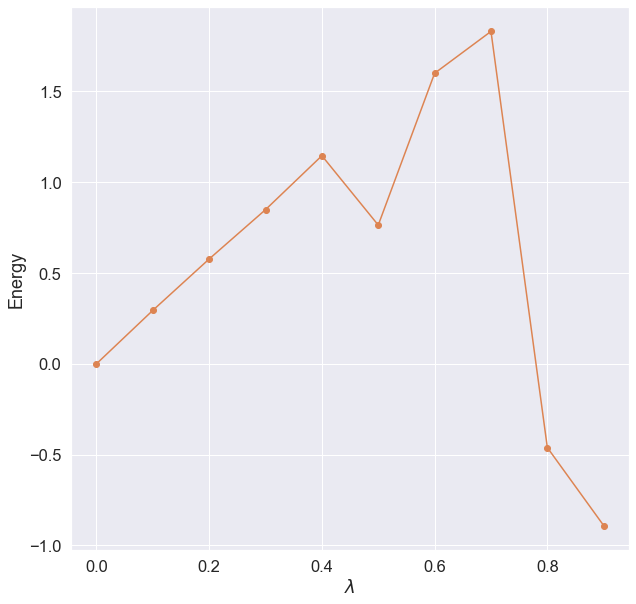

In [6]:
lmbvalues_qk = np.linspace(0, 1 - 1/n_points, n_points)
print(lmbvalues_qk.shape)
print(min_energy_qk.shape)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.plot(lmbvalues_qk, min_energy_qk, label = 'Qiskit', color = '#dd8452', marker = 'o')
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Energy')
plt.show()